In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from resizeimage import resizeimage
from PIL import Image
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import math

n_channels = 3 # color image has 3 channels

In [69]:
def add_random_brightness(image_data):
    # Convert to HSV from RGB
    hsv = cv2.cvtColor(image_data, cv2.COLOR_RGB2HSV)
    # Generate random number to apply to brightness channel
    rand = random.uniform(0.3,1.0)
    hsv[:,:,2] = rand*hsv[:,:,2]
    # Convert back to RGB colorspace
    processed_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return processed_img 

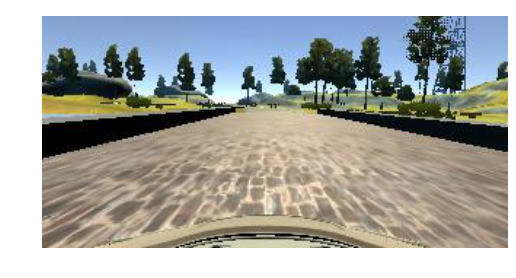

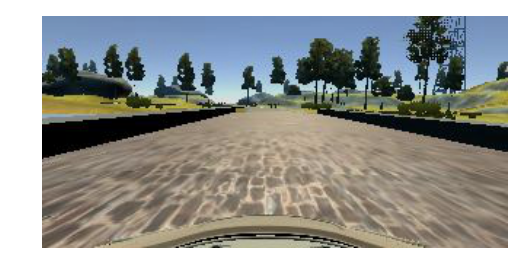

In [70]:
# test add_random_brightness
img = cv2.imread('test.jpg')
processed_img = add_random_brightness(img)
#show before image
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#show after image
plt.axis("off")
plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
plt.show() 

In [71]:
# parameters for the model
EPOCHS = 8 
img_width, img_height = 320, 160
RESIZE_IMAGE_W = 64
RESIZE_IMAGE_H = 64
batch_size = 128
user_data = False
n_split_train_data = 0 # will be determined at run time based on actual number of samples
n_val_data = 0         # will be determined at run time based on actual number of samples
CROP_PIXEL_FROM_TOP = 60
CROP_PIXEL_FROM_BOTTOM = 20

In [72]:
# Crop the sky and car hood
def crop_image(image_data):
    shape = image_data.shape
    cropped_img = image_data[CROP_PIXEL_FROM_TOP:shape[0]-CROP_PIXEL_FROM_BOTTOM,:]
    return cropped_img

In [73]:
if (user_data == True):
  csv_file_path = 'driving_log.csv'
else:
  csv_file_path = 'data//driving_log.csv'

In [74]:
# this is the output labels for each frame
driving_log = pd.read_csv(csv_file_path)
steering_angles = driving_log['steering']
steering_angles = np.array(steering_angles)
n_train_data = steering_angles.shape[0]
print('number of train data is {}'.format(n_train_data))

if user_data == True:
  image_file_names = driving_log['center']
else:
  image_file_names = 'data//' + driving_log['center']

number of train data is 5732


In [75]:
# y_train = []
# x_train = []
# # get data from disk
# for index in range(n_train_data):
#   #global y_train
#   y = np.array(steering_angles[index])
#   y_train.append(y)
#   #global x_train
#   x = cv2.imread(image_file_names[index],cv2.IMREAD_COLOR)
#   x = add_random_brightness(x)
# ## test print the image
# #   if (index == 1):
# #     cv2.imshow('test train image',x)
# #     cv2.waitKey(0)
# #     cv2.destroyAllWindows()
#   x = cv2.resize(x, (RESIZE_IMAGE_W, RESIZE_IMAGE_H))
#   x_train.append(x)


# x_train = np.asarray(x_train)
# y_train = np.asarray(y_train)
# print('shape of x_train is {}'.format(x_train.shape))
# print('shape of y_train is {}'.format(y_train.shape))
# print('x_train[0] is {}'.format(x_train[0]))

# # split the data to training set and validation set
# # x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.1, random_state = 0)

# print('length of x_train is {}'.format(len(x_train)))
# print('length of y_train is {}'.format(len(y_train)))
# # print('length of x_validation is {}'.format(len(x_validation)))
# # print('length of y_validation is {}'.format(len(y_validation)))
# print('type of x_train is {}'.format(type(x_train)))
# print('type of y_train is {}'.format(type(y_train)))

# # shuffle the training data
# x_train, y_train = shuffle(x_train, y_train)

In [76]:
# define the model with Keras
nb_filters = 32
nb_filters_2 = 64
nb_filters_3 = 128
kernel_size_w = 3
kernel_size_h = 3
dropout = 0.5
print('shape of steering_angles is {}'.format(steering_angles.shape))
input_shape = (RESIZE_IMAGE_H, RESIZE_IMAGE_W, n_channels)
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape = input_shape))
model.add(Convolution2D(nb_filters, kernel_size_w, kernel_size_h, border_mode='valid', subsample =(2,2)))
model.add(Dropout(dropout))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters_2, kernel_size_w, kernel_size_h, border_mode='valid', subsample =(2,2)))
model.add(Dropout(dropout))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters_3, kernel_size_w, kernel_size_h, border_mode='valid', subsample =(2,2)))
model.add(Dropout(dropout))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(dropout))
model.add(LeakyReLU(alpha=.3))   # add an advanced activation
model.add(Dense(64))
model.add(LeakyReLU(alpha=.3))   # add an advanced activation
model.add(Dense(16))
model.add(LeakyReLU(alpha=.3))   # add an advanced activation
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])

shape of steering_angles is (5732,)


In [77]:
def select_image_and_process(index, data_type='train'):
    # pick a random image from one of the cameras: (left, center, right)
    # and add/subtract angles if necessary
    random_choice = np.random.randint(3)
    if (random_choice == 0):
        img_file = 'data//' + driving_log['left'].str.strip()
    shift_ang = .25
    if (random_choice == 1):
        img_file = 'data//' + driving_log['center'].str.strip()
        shift_ang = 0.
    if (random_choice == 2):
        img_file = 'data//' + driving_log['right'].str.strip()
        shift_ang = -.25  

    # create Numpy arrays of input data
    # and labels, using each row in the csv file
    x = cv2.imread(img_file[index], cv2.IMREAD_COLOR)
    # show before image
    if (index==0 or index==7000):
        plt.axis("off")
        plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
        plt.show()
    if data_type =='train':
        x = add_random_brightness(x)
        x = crop_image(x)
        # check image has been processed
        # show after image
        if (index==0 or index==7000):
            plt.axis("off")
            plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
            plt.show()
        
    x = cv2.resize(x, (RESIZE_IMAGE_W, RESIZE_IMAGE_H), interpolation=cv2.INTER_AREA)
    y = np.array(steering_angles[index])
    y = np.add(y, shift_ang)
    
    # randomly fiip the image
    should_flip = np.random.randint(2)
    if should_flip==1:
        x = cv2.flip(x,1)
        y = -y
    
    return x, y # x: processed image, y: processed angle

In [78]:
def data_generator_with_batch(path, batch_size, split=0.1, data_type='train'):
    global n_val_data, n_split_train_data
    n_val_data = int(n_train_data*split)
    n_split_train_data = n_train_data - n_val_data

    # calculate number of batches
    if data_type =='train':
        number_of_batch = math.ceil(n_split_train_data/batch_size)
        offset = 0
        number_of_samples = n_split_train_data
    else:
        number_of_batch = math.ceil(n_val_data/batch_size)
        offset = n_split_train_data
        number_of_samples = n_val_data
    # calculate the last batch size
    if (number_of_samples % batch_size == 0):
        last_batch_size = batch_size
    else:
        last_batch_size = (number_of_samples % batch_size)

    while 1:
        for batch_i in range(number_of_batch):
            # start out as 1, i.e. chance of dropping small angles is high in early rounds
            pr_threshold = 1 / (batch_i+1) 
            x_batch = []
            y_batch = []

            # check if we are not in last batch
            if (batch_i < (number_of_batch - 1)):
                for i in range(batch_size):
                    random_pick = np.random.randint(n_train_data)
                    keep_pr = 0
                    while keep_pr == 0:
                        x, y = select_image_and_process(random_pick, data_type)
                        # if the angle is too small, we may need to drop this training data so that
                        # it has less influence on the learning
                        if abs(y) < 0.1:
                            pr_val = np.random.uniform()
                            if pr_val > pr_threshold:
                                keep_pr = 1
                        else:
                            keep_pr = 1
                    
                    x_batch = np.append(x_batch, x)
                    y_batch = np.append(y_batch, y)
                    x_batch = np.asarray(x_batch)
                    y_batch = np.asarray(y_batch)
                # reshape the batch for the model
                X = x_batch.reshape(batch_size,RESIZE_IMAGE_H, RESIZE_IMAGE_W,n_channels)
                Y = y_batch.reshape(batch_size,1)
                yield X, Y
            else:
                # the last batch
                for i in range(last_batch_size):
                    random_pick = np.random.randint(n_train_data)
                    keep_pr = 0
                    while keep_pr == 0:
                        x, y = select_image_and_process(random_pick, data_type)
                        # if the angle is too small, we may need to drop this training data so that
                        # it has less influence on the learning
                        if abs(y) < 0.1:
                            pr_val = np.random.uniform()
                            if pr_val > pr_threshold:
                                keep_pr = 1
                        else:
                            keep_pr = 1
                    x_batch = np.append(x_batch, x)
                    y_batch = np.append(y_batch, y)
                    x_batch = np.asarray(x_batch)
                    y_batch = np.asarray(y_batch)
                # reshape the batch for the model
                X = x_batch.reshape(last_batch_size,RESIZE_IMAGE_H, RESIZE_IMAGE_W,n_channels)
                Y = y_batch.reshape(last_batch_size,1)
                yield X, Y

In [79]:
train_generator = data_generator_with_batch(csv_file_path, batch_size)
validation_generator = data_generator_with_batch(csv_file_path, batch_size, data_type='validation')
print(next(train_generator))
print(next(validation_generator))
model.fit_generator(train_generator, samples_per_epoch=n_split_train_data, 
    nb_epoch=EPOCHS, validation_data=validation_generator, nb_val_samples=n_val_data)
# model.fit_generator(train_generator, samples_per_epoch=n_split_train_data, nb_epoch=3)

(array([[[[  66.,  175.,  187.],
         [  47.,  158.,  170.],
         [  66.,  169.,  184.],
         ..., 
         [  57.,   79.,   90.],
         [  61.,   87.,   99.],
         [  61.,   89.,  104.]],

        [[  62.,  174.,  183.],
         [  57.,  169.,  181.],
         [  55.,  157.,  175.],
         ..., 
         [ 109.,  110.,   99.],
         [ 109.,  112.,  104.],
         [ 108.,  113.,  106.]],

        [[  59.,  173.,  181.],
         [  68.,  181.,  193.],
         [  57.,  161.,  179.],
         ..., 
         [ 188.,  170.,  140.],
         [ 186.,  169.,  142.],
         [ 184.,  169.,  143.]],

        ..., 
        [[ 102.,  115.,  113.],
         [ 109.,  121.,  119.],
         [  98.,  110.,  109.],
         ..., 
         [  66.,   69.,   75.],
         [  81.,   77.,   89.],
         [  62.,  131.,  136.]],

        [[  92.,  104.,  105.],
         [ 106.,  118.,  119.],
         [ 100.,  112.,  113.],
         ..., 
         [  57.,   74.,   75.],
      

KeyboardInterrupt: 

In [67]:
# save the model and trained weights
model_name = 'model.json'
model_json = model.to_json()
with open(model_name, "w") as json_file:
    json_file.write(model_json)
    print("model saved to disk as {}".format(model_name))
model_weight_name = 'model.h5'
model.save_weights(model_weight_name)  # save the weights after training or during training
print("model weight saved to disk as {}".format(model_weight_name))

model saved to disk as model.json
model weight saved to disk as model.h5
